## Analysis, Prediction, Recommendation For Churn Rate of a telecom
Raymond Kwok 23 June 2019 (rmwkwok at gmail.com)

# Purpose
1. Given a < 1MB telecom client dataset of 7043 rows and 21 columns, I shall analyze the dataset and produce a prediction model of churn probability, and find out how the probability depends on features and how to reduce it. One interesting point is that some columns' names are encoded and I will define them based on my understanding.

2. This work has 3 notebooks. 
    - This one focuses on exploratory data analysis and feature engineering, that an engineered dataset is produced at the end
    - The dataset will be used in the second notebook for modeling with several approaches, among which I will select the best one based on a few metrics and I will show the feature's importance for the selected model
    - In the last notebook, I will suggest for actions that, based on the model, could effectively reduce the churn rate

## TOC
<a href=#a >A. Data cleaning, and guess column names</a><br><br>
<a href=#b >B. Create new features!</a><br>
<a href=#b1>>>B1 life time: retention curve -> relative churn probability</a><br>
<a href=#b2>>>B2 life time: distribution -> 1. churn probability 2. cumulative churn probability</a><br>
<a href=#b3>>>B3 unsupervised expected life time</a><br><br>
<a href=#c >C. Feature engineering</a><br>
<a href=#c1>>>C1 back to B3</a><br><br>
<a href=#d >D. Summary</a><br><br>
<a href=#e >E. Summary</a>

# Exploratory Data Analysis

## A. Data cleaning, and guess column names <a name='a' /></a>

In [1]:
# packages
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from scipy.optimize import curve_fit as cfit
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# self-defined functions in a separate file
from util import showSummary, showCorr, randColor, rootmeansquared

%load_ext autoreload
%autoreload 2

#rows, #columns =  (7043, 21)


general                 numeric stats                     \
               datatype #nonMissingData         count   mean    std  min   
uid               int64            7043        7043.0 3521.0 2033.3  0.0   
gend             object            7043                                    
Factor_00         int64            7043        7043.0    0.2    0.4  0.0   
Factor_01        object            7043                                    
Factor_02        object            7043                                    
Factor_03         int64            7043        7043.0   32.4   24.6  0.0   
Service_01       object            7043                                    
Service_02       object            7043                                    
Service_03       object            7043                                    
Service_04       object            7043                                    
Service_05       object            7043                                    
service_06       object            7043                                    
Service_07       object            7043                                    
Service_08       object            7043                                    
Service_09       object            7043                                    
C_01             object            7043                                    
C_02             object            7043                                    
C_03             object            7043                                    
MonthlyCharges  float64            7043        7043.0   64.8   30.1 18.2   
Charges         float64            7032        7032.0 2283.3 2266.8 18.8   
is_churn         object            7043                                    

                                           categoric stats  \
                  25%    50%    75%    max   #uniqueValues   
uid            1760.5 3521.0 5281.5 7042.0            7043   
gend                                                     2   
Factor_00         0.0    0.0    0.0    1.0               2   
Factor_01                                                2   
Factor_02                                                2   
Factor_03         9.0   29.0   55.0   72.0              73   
Service_01                                               2   
Service_02                                               3   
Service_03                                               3   
Service_04                                               3   
Service_05                                               3   
service_06                                               3   
Service_07                                               3   
Service_08                                               3   
Service_09                                               3   
C_01                                                     3   
C_02                                                     2   
C_03                                                     4   
MonthlyCharges   35.5   70.3   89.8  118.8            1585   
Charges         401.4 1397.5 3794.7 8684.8            6530   
is_churn                                                 2   

                                                                   \
                                                     uniqueValues   
uid                                                                 
gend                                                  Female,Male   
Factor_00                                                     0,1   
Factor_01                                                  Yes,No   
Factor_02                                                  No,Yes   
Factor_03                                                           
Service_01                                                 No,Yes   
Service_02                                No phone service,No,Yes   
Service_03                                     DSL,Fiber optic,No   
Service_04                             No,Yes,No internet service   
Service_05  

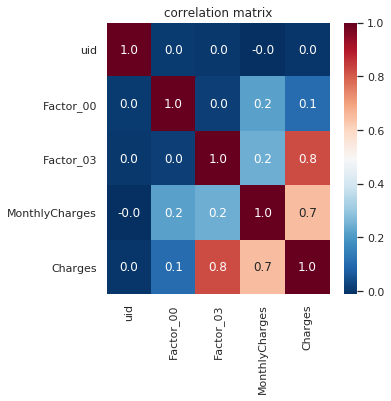

In [2]:
# read data
rawdata = pd.read_csv('./dataset_telecom_01.csv')

# Take a glance
showSummary(rawdata)
showCorr(rawdata, font_scale=1)


Observations:
1. uid: can be dropped
    - uid looks find as it has an unique value for everyone
    - uid has some power if it is chronological, which is NOT the case as it has no correlation (0.0) with 'Charges'. The uid looks randomly assigned.
2. Factor_03 as numeric feature. Those with < 5 unique values as categoric features.
    - Factor_03 has 73 unique values, and it could be categoric. However it has high correlation (0.8) with 'Charges', suggesting that the size of the value matters, thus a numeric feature.
3. Charges: has missing data, will look into it next.

In [3]:
# observation 3: missing data
with pd.option_context('display.max_rows', 100, 
                       'display.max_columns', 100):
    display(rawdata[rawdata['Charges'].isna()])

,uid,gend,Factor_00,Factor_01,Factor_02,Factor_03,Service_01,Service_02,Service_03,Service_04,Service_05,service_06,Service_07,Service_08,Service_09,C_01,C_02,C_03,MonthlyCharges,Charges,is_churn
488,488,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,No,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),52.55,NaN,No
753,753,Male,0,No,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.25,NaN,No
936,936,Female,0,Yes,Yes,0,Yes,No,DSL,Yes,Yes,Yes,No,Yes,Yes,Two year,No,Mailed check,80.85,NaN,No
1082,1082,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.75,NaN,No
1340,1340,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,Yes,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),56.05,NaN,No
3331,3331,Male,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,19.85,NaN,No
3826,3826,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.35,NaN,No
4380,4380,Female,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.00,NaN,No
5218,5218,Male,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,19.70,NaN,No
6670,6670,Female,0,Yes,Yes,0,Yes,Yes,DSL,No,Yes,Yes,Yes,Yes,No,Two year,No,Mailed check,73.35,NaN,No


Observations:
4. missing charges: drop those rows
    - Min value for 'Charges' is 18.8. If the telecom charges client at the end of service month, then a new client's 'Charges' should be 0. This theory can't be verified and to avoid the risk of mis-interpretation, and these are only 0.15% of the dataset, I would drop them.

In [4]:
# observation 1: drop uid 
dataset = rawdata.drop('uid', axis=1)

# observation 4: drop missing rows
dataset = dataset.dropna(axis=0)

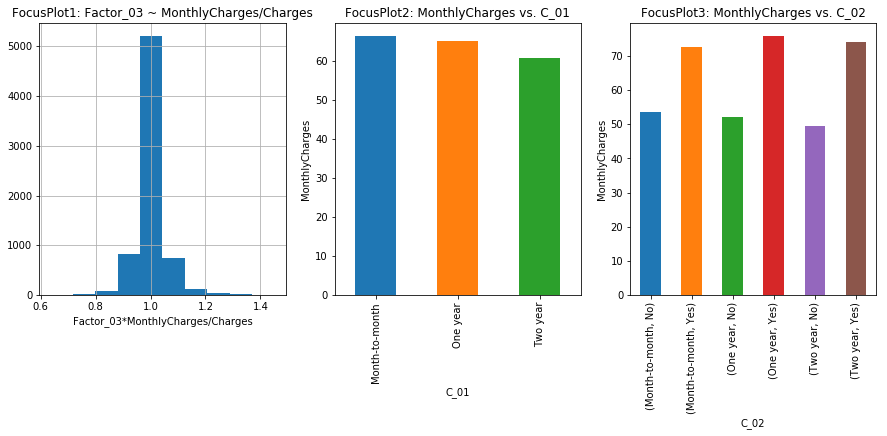

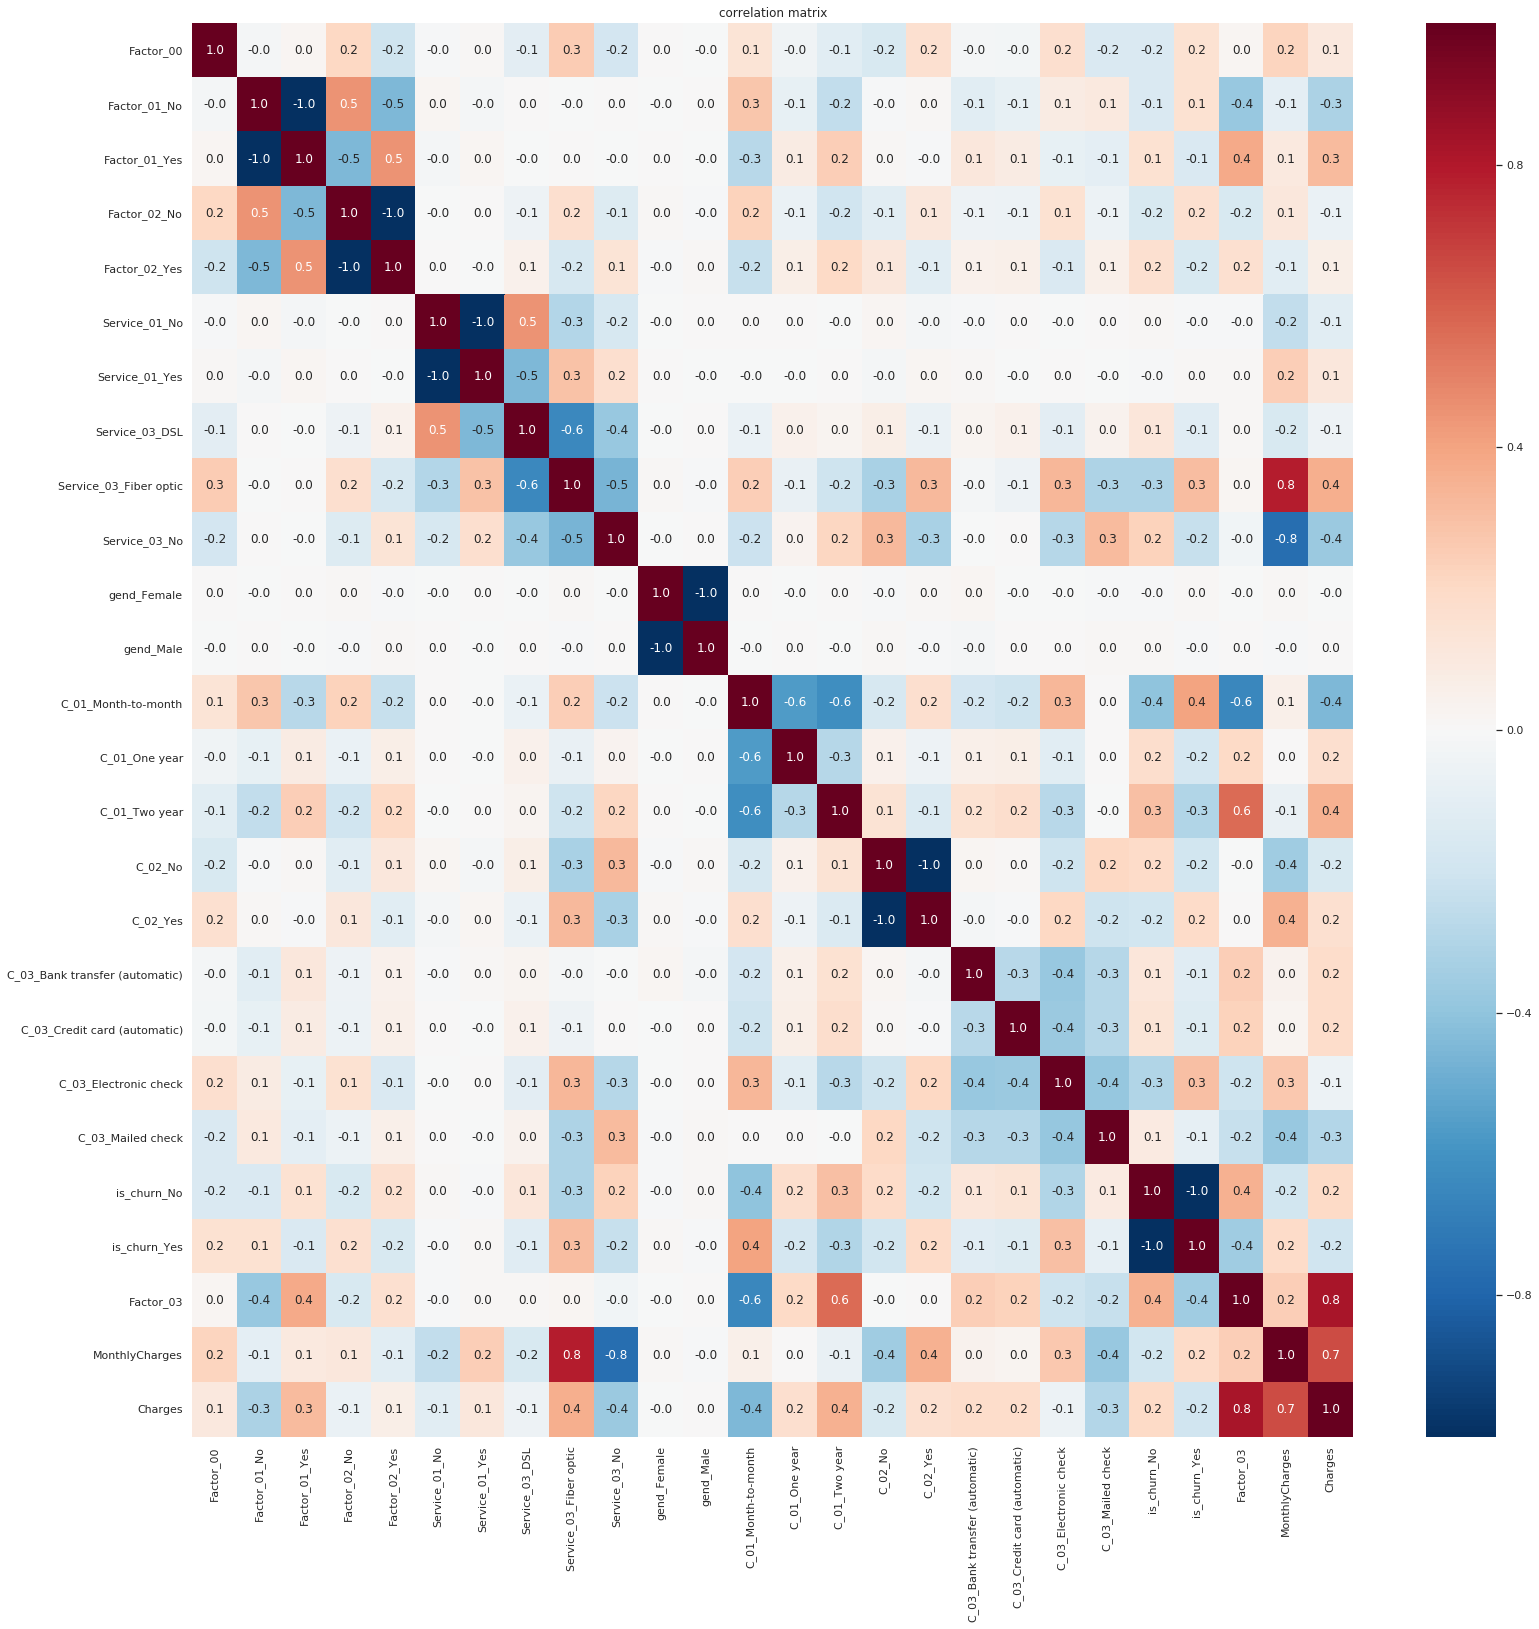

In [5]:
# make a few focus plots to guess column definitions

fig, axes = plt.subplots(1,3,figsize=(15,5))
axes = axes.flatten()

# plot 1
ax = axes[0]
(dataset['Factor_03'] * dataset['MonthlyCharges'] / dataset['Charges']).hist(ax=ax)
ax.set_title('FocusPlot1: Factor_03 ~ MonthlyCharges/Charges')
ax.set_xlabel('Factor_03*MonthlyCharges/Charges')

# plot 2
ax = axes[1]
dataset.groupby('C_01')['MonthlyCharges'].mean().plot.bar(ax=ax)
ax.set_title('FocusPlot2: MonthlyCharges vs. C_01')
ax.set_xlabel('C_01')
ax.set_ylabel('MonthlyCharges')

# plot 3
ax = axes[2]
dataset.groupby(['C_01','C_02'])['MonthlyCharges'].mean().plot.bar()
ax.set_title('FocusPlot3: MonthlyCharges vs. C_02')
ax.set_xlabel('C_02')
ax.set_ylabel('MonthlyCharges')

# plot 4
tmp = pd.get_dummies(dataset[['Factor_00', 'Factor_01', 'Factor_02', 
                              'Service_01', 'Service_03', 'gend', 
                              'C_01', 'C_02', 'C_03', 'is_churn']])\
        .join(dataset[['Factor_03', 'MonthlyCharges', 'Charges']])
showCorr(tmp, font_scale=1)
plt.show()

Observations:

5. Columns guessing
    - gend: Gender
    - MonthlyCharges: Recent monthly charge
    - Charges: Total charged fee
    
    - Factor_03: LifetimeInMonth
        - FocusPlot1: Factor_03 * MonthlyCharges / Charges ~ 1, Factor_03 has the unit of month, and thus a lifetime, or how long a client is with the telecom.
    - C_01: SubscriptionPeriod
        - Guess from its values: month, year, or two-year. FocusPlot2 verifies that shorter period charges more.
    - C_02: ExpensivePaymentChoice
        - FocusPlot3: charges more when 'yes', and the assumption that C_0x is about payment
    - Factor_00: Factor_FiberGroup 
        - FocusPlot3: Positively correlated with Using Fiber Internet
    - Factor_01: Factor_loyalGroup
        - FocusPlot3: Positively correlated with SubscriptionPeriod and Lifetime
    - Factor_02: Factor_loyalGroupForPhoneService
        - FocusPlot3: Positively correlated with SubscriptionPeriod, Lifetime, and unlikely to use Internet
        
    - Service_02: PhoneService_addon
        - Guess from its values: 'No phone service' indicates phone service is a pre-requisite
    - Service_03: InternetService.
        - Guess from its values: DSL and Fiber optics are internet types
    - Service_04-09: InternetService_addon
        - Guess from its values: 'No internet service' indicates internet is a pre-requisite
    - Service_01: PhoneService
        - Only possible column for phone service
    - C_03: PaymentChannel
        - Guess from its values.

In [6]:
# Observation 5: rename columns
# rename columns according to observtion 7
dataset = dataset.rename(columns={'gend':'gender',
                                  'Factor_00':'Factor_FiberGroup',
                                  'Factor_01':'Factor_loyalGroup',
                                  'Factor_02':'Factor_loyalGroupForPhoneService',
                                  'Factor_03':'LifetimeInMonth',
                                  'Service_01':'PhoneService',
                                  'Service_02':'PhoneService_addon',
                                  'Service_03':'InternetService',
                                  'Service_04':'InternetService_addon1',
                                  'Service_05':'InternetService_addon2',
                                  'service_06':'InternetService_addon3',
                                  'Service_07':'InternetService_addon4',
                                  'Service_08':'InternetService_addon5',
                                  'Service_09':'InternetService_addon6',
                                  'C_01':'SubscriptionPeriod',
                                  'C_02':'ExpensivePaymentChoice',
                                  'C_03':'PaymentChannel'})

understanding overview
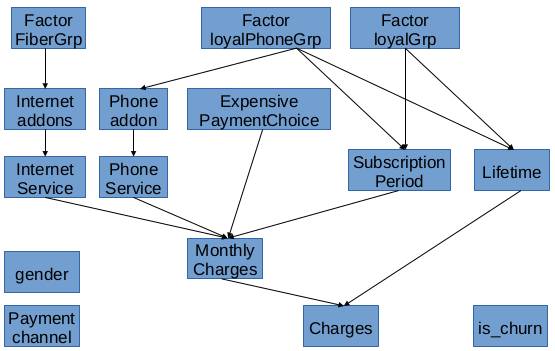

## B. Create new features! <a name='b' /></a>

### B1 life time: retention curve -> relative churn probability  <a name='b1' /></a>

Retention is a common way to observe how quickly clients leave. If all of them leave with the same probability, the retention curve goes down exponentially.

In general, one draws the curve by groupping client with the same join period, but this info is missing with this dataset. Thus I will focus on churn clients, assuming them joined at the same time, and stayed for the period of their Lifetimes. 

This is an approximation assuming that overall clients' behavior does't change over time.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:45: RuntimeWarning: overflow encountered in exp


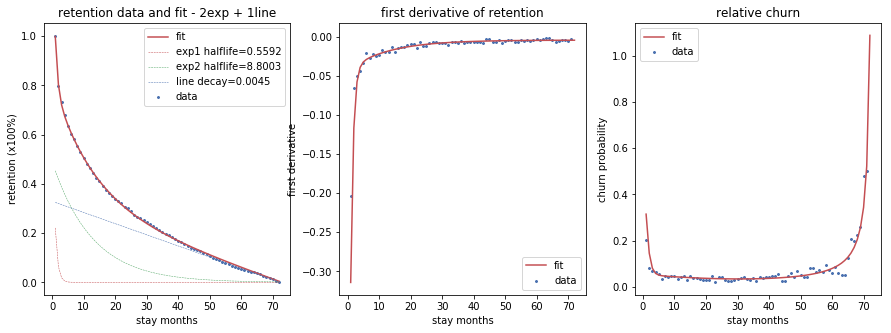

In [7]:
fig, axes = plt.subplots(1,3,figsize=(15,5))
axes = axes.flatten()

#######################
## get retention curve
#######################
# pick left clients
tmp = dataset[dataset['is_churn']=='Yes']['LifetimeInMonth'].value_counts().sort_index()

# get frequency (y) of life time values (x)
x = tmp.index.values
y = tmp.values

# cumulatively sum y to get how clients drop over time, and normalize
y = np.flip(np.flip(y).cumsum()) / sum(y)

#######################
## get first derivative of retention curve
## to understand how y changes with x
#######################
dy   = y[1:]-y[:-1]
dy_x = x[:-1]

ax = axes[1]
ax.scatter(dy_x, dy, marker='x', c='b', s=4, label='data')
ax.set_title('first derivative of retention')
ax.set_xlabel('stay months')
ax.set_ylabel('first derivative')

#######################
## get percentage change of retention
#######################
dy_by_y   = -dy/y[:-1]
dy_by_y_x = dy_x

ax = axes[2]
ax.scatter(dy_by_y_x, dy_by_y, marker='x', c='b', s=4, label='data')
ax.set_title('relative churn')
ax.set_xlabel('stay months')
ax.set_ylabel('churn probability')

##########################
## basic fitting func
##########################
fn_exp = lambda x,a,b: a*np.exp(-b*x)
fn_lin = lambda x,a,b: -a*x+b

##########################
## fitting retention curve 1:
## two exponentials + a line
##########################
# function
fn_2exp     = lambda x,a,b,c,d    : fn_exp(x,a,b) + fn_exp(x,c,d)
fn_2exp_lin = lambda x,a,b,c,d,e,f: fn_2exp(x,a,b,c,d) + fn_lin(x,e,f)

# fit x>=50 with a line
x1 = x[np.argwhere(x>=50)].flatten()
y1 = y[np.argwhere(x>=50)].flatten()
(e,f), _ = cfit(fn_lin, x1, y1)

# fit the residual with two exponentials
x2 = x
y2 = y - fn_lin(x,e,f)
(a,b,c,d), _ = cfit(fn_2exp, x2, y2)

# plot result
ax = axes[0]
ax.scatter(x, y, marker='x', c='b', s=4, label='data')
ax.plot(x, fn_2exp_lin(x,a,b,c,d,e,f), c='r', label='fit')
ax.plot(x, fn_exp(x,a,b), c='r', ls='--', lw=.5, label='exp1 halflife=%.4f'%(np.log(2)/b))
ax.plot(x, fn_exp(x,c,d), c='g', ls='--', lw=.5, label='exp2 halflife=%.4f'%(np.log(2)/d))
ax.plot(x, fn_lin(x,e,f), c='b', ls='--', lw=.5, label='line decay=%.4f'%e)
ax.set_title('retention data and fit - 2exp + 1line')
ax.set_xlabel('stay months')
ax.set_ylabel('retention (x100%)')
ax.legend()

##########################
## get derivative of the 2exp1lin model
## and overlay it on the first derivative data plot
## and retention percentage change plot
##########################
dy_model = lambda x,a,b,c,d,e,f: -(b*fn_exp(x,a,b) + d*fn_exp(x,c,d) + e)

ax = axes[1]
ax.plot(x, dy_model(x,a,b,c,d,e,f), c='r', label='fit')
ax.legend()

dy_by_y_model = lambda x,a,b,c,d,e,f: -dy_model(x,a,b,c,d,e,f)/fn_2exp_lin(x,a,b,c,d,e,f)
ax = axes[2]
ax.plot(x, dy_by_y_model(x,a,b,c,d,e,f), c='r', label='fit')
ax.legend()

plt.show()

relative_churn_prob = [ dy_by_y_model(_x,a,b,c,d,e,f) for _x in range(100) ]

Observations:
1. LeftPlot: Retention does not drop exponentially, but having 3 processes, namely,
    - 2 exponential lines with different lifetime ~1 (25% clients), and ~9 (45% clients) months respectively
    - 1 line with decay rate of 0.45%/month
2. MiddlePlot: Differencing or First derivative of retention
3. RightPlot: First derivative divided by Retention, giving us the relative churn probability

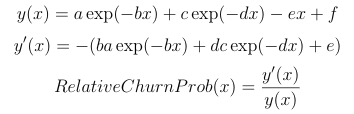

### B2 life time: distribution -> 1. churn probability 2. cumulative churn probability <a name='b2' /></a>

Distribution plot for lifetime predicts client's churn likelihood (1) at certain month, based on the assumption that clients behave similarly throughout all time.

The integration of the above plot (cumulative plot) gives us a sum of churn probability up to certain month. It will grow as client stays longer, trying to address the assumption that churn probability gros over time.

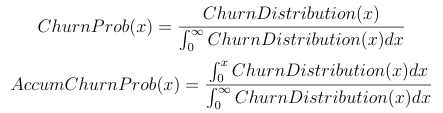

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: overflow encountered in exp
No handles with labels found to put in legend.


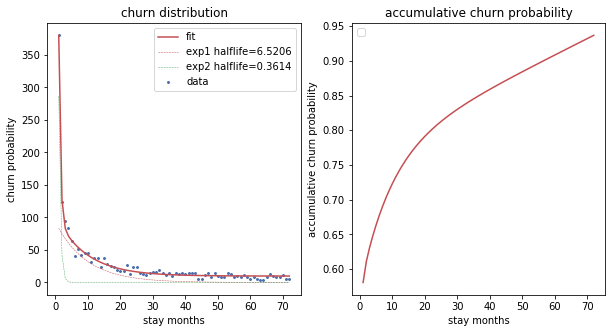

In [8]:
fig, axes = plt.subplots(1,2,figsize=(10,5))
axes = axes.flatten()

#######################
## get distribution
#######################

# pick left clients
tmp = dataset[dataset['is_churn']=='Yes']['LifetimeInMonth'].value_counts().sort_index()

# get frequency (y) of life time values (x)
x = tmp.index.values
y = tmp.values

##########################
## fitting distribution curve:
## two exponentials 
##########################

# function
fn_exp  = lambda x,a,b : a*np.exp(-b*x)
fn_2exp = lambda x,a,b,c,d,e : fn_exp(x,a,b) + fn_exp(x,c,d) + e

# fit 
(a,b,c,d,e), _ = cfit(fn_2exp, x, y)

# utility func - for feature engineering
churn_prob = fn_2exp(np.arange(100),a,b,c,d,e)
churn_prob = churn_prob/sum(churn_prob)

# plot result
ax = axes[0]
ax.scatter(x, y, marker='x', c='b', s=4, label='data')
ax.plot(x, fn_2exp(x,a,b,c,d,e), c='r', label='fit')
ax.plot(x, fn_exp(x,a,b), c='r', ls='--', lw=.5, label='exp1 halflife=%.4f'%(np.log(2)/b))
ax.plot(x, fn_exp(x,c,d), c='g', ls='--', lw=.5, label='exp2 halflife=%.4f'%(np.log(2)/d))
ax.set_title('churn distribution')
ax.set_xlabel('stay months')
ax.set_ylabel('churn probability')
ax.legend()

##########################
## get accumulative probability curve:
##########################

# utility func - for feature engineering
accum_churn_prob = fn_2exp(np.arange(100),a,b,c,d,e).cumsum()
accum_churn_prob = accum_churn_prob/max(accum_churn_prob)

# plot result
ax = axes[1]
ax.plot(x, accum_churn_prob[x], c='r')
ax.set_title('accumulative churn probability')
ax.set_xlabel('stay months')
ax.set_ylabel('accumulative churn probability')
ax.legend()

plt.show()

## B3 unsupervised expected life time <a name='b3' /></a>
This part groups churn clients by K-means. Then each group bears an expected lifetime equal to the average lifetime of group members. The intention is that user's lifetime can be guessed from their features.

This exploration will be continued after part C, where we will transform all features into numeric values, and that is the pre-requisite for K-means.

## C. Feature engineering <a name='c' /></a>

Let's get straight to what will be done:
1. Add
    - RelativeChurnProb
        - explained in B1
    - AccumChurnProb, ChurnProb
        - explained in B2
    - PayTrend: ( MonthlyCharges - Charges/Lifetime ) / ( Charges/Lifetime )
        - Positive value means client's recent monthly fee is more than history average, which could be a sign that the client is satisifed with the service.
    - NumberOfAddons
        - count how many yes among InternetService_addon(1...6) and PhoneService_addon

2. Label encoding
    - gender
        - 'Male' -> 1, 'Female' -> 0
    - Factor_loyalGroup, Factor_loyalGroupForPhoneService, is_churn, ExpensivePaymentChoice, PhoneService
        - 'Yes' -> 1, 'No' -> 0
    - (Phone, Internet)Service_addon(1...6) -> Use(Phone, Internet)AndServiceAddon(1...6)
        - 'Yes' -> 1, else -> 0
    - InternetService -> UseDSLInternetService + UseFiberInternetService
        - UseDSLInternetService: 'DSL' -> 1 else -> 0
        - UseFiberInternetService: 'Fiber optic' -> 1 else -> 0
    - SubscriptionPeriod, PaymentChannel
        - one-hot encoding


In [9]:
# Add new features
dataset['NumberOfAddons'] = dataset[['PhoneService_addon', 
                                     'InternetService_addon1', 'InternetService_addon2', 
                                     'InternetService_addon3', 'InternetService_addon4', 
                                     'InternetService_addon5', 'InternetService_addon6']]\
                            .apply(lambda r: sum(r=='Yes'), axis=1)
dataset['PayTrend'] = dataset['MonthlyCharges']*dataset['LifetimeInMonth']/dataset['Charges'] - 1
dataset['RelativeChurnProb'] = dataset['LifetimeInMonth'].apply(lambda x: relative_churn_prob[int(x)])
dataset['AccumChurnProb'] = dataset['LifetimeInMonth'].apply(lambda x: accum_churn_prob[x])
dataset['ChurnProb'] = dataset['LifetimeInMonth'].apply(lambda x: churn_prob[x])

# label encoding
dataset['gender'] = (dataset['gender'] == 'Male').astype(int)

tmp = ['Factor_loyalGroup', 'Factor_loyalGroupForPhoneService', 'ExpensivePaymentChoice', 
       'PhoneService', 'is_churn', 'PhoneService_addon', 
       'InternetService_addon1', 'InternetService_addon2', 'InternetService_addon3',
       'InternetService_addon4', 'InternetService_addon5', 'InternetService_addon6']
dataset[tmp] = (dataset[tmp] == 'Yes').astype(int)

dataset = dataset.rename(columns={'PhoneService_addon':'UsePhoneAndService_addon',
                                  'InternetService_addon1':'UseInternetAndService_addon1',
                                  'InternetService_addon2':'UseInternetAndService_addon2',
                                  'InternetService_addon3':'UseInternetAndService_addon3',
                                  'InternetService_addon4':'UseInternetAndService_addon4',
                                  'InternetService_addon5':'UseInternetAndService_addon5',
                                  'InternetService_addon6':'UseInternetAndService_addon6'})

dataset['UseDSLInternetService']   = (dataset['InternetService'] == 'DSL').astype(int)
dataset['UseFiberInternetService'] = (dataset['InternetService'] == 'Fiber optic').astype(int)
dataset = dataset.drop('InternetService', axis=1)

tmp = ['SubscriptionPeriod', 'PaymentChannel']
dataset[tmp] = dataset[tmp].replace(' ','_')
dataset = dataset.join(pd.get_dummies(dataset[tmp]).astype(int)).drop(tmp, axis=1)

### C1: back to B3 <a name='c1' /></a>
Kind reminder: this work groups clients by their features, and label each group an expected lifetime value as the group member's average lifetime.

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  if sys.path[0] == '':


scaling lifetime feature by 0 vertical lines indicate medians


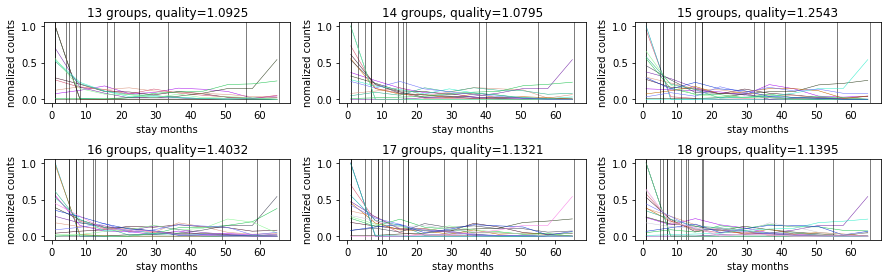

scaling lifetime feature by 10 vertical lines indicate medians


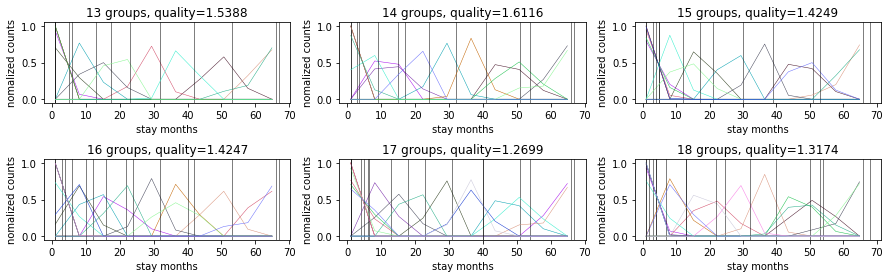

In [10]:
# pick left clients
tmp = dataset[dataset['is_churn']==1].drop('is_churn', axis=1)

# keep a copy of lifetime column
tmp_lifetime = tmp['LifetimeInMonth'].values

# index of column label for 'LifetimeInMonth'
idx_lifetime = np.argwhere(tmp.columns=='LifetimeInMonth')[0][0]

# standardize feature values for K-means 
feat_scaler = StandardScaler().fit(tmp)
tmp = feat_scaler.transform(tmp)

# dictionary to save all models
allmodels = {}

# this loop tries different scaling for lifetime
# 0 is the preferred choice as it will disable lifetime from grouping
# 10 gives strong bias to lifetime. expecting to see evenly distributed groups over lifetime domain
for amp in [0,10]:
    print('scaling lifetime feature by %d'%amp,
          'vertical lines indicate medians')
    _tmp = tmp.copy()
    _tmp[:,idx_lifetime] = amp*_tmp[:,idx_lifetime]  # scale up here
    
    # initialize dict
    allmodels[amp] = {}
    
    # try K-means with following k values
    n_range = range(13,19)
    
    # get ready to plot
    ncol = 3
    nrow = int(np.ceil(len(n_range)/ncol))
    fig, axes = plt.subplots(nrow,ncol,figsize=(5*ncol,2*nrow))
    axes = axes.flatten()

    for ax, n in zip(axes, n_range):
        # fit K-means
        km = KMeans(n_clusters=n, n_init=8, max_iter=300, 
                    random_state=3, n_jobs=4)
        km.fit(_tmp)
        result = pd.DataFrame({'LifetimeInMonth':tmp_lifetime,
                               'group': km.labels_})\
                   .sort_values('group')
        
        # count how many clients in each group for quality measure
        # more evenly distributed the better
        nClientsPerGroup   = result.groupby('group')\
                                   .count()['LifetimeInMonth']\
                                   .values
        
        # get lifetime median for each group
        # difference of adjacent medians used for quality measure
        # more evenly distributed the better
        medianLifeTime     = result.groupby('group')\
                                   .median()['LifetimeInMonth']\
                                   .values
        medianLifeTimeDiff = np.diff(sorted(medianLifeTime))
        
        
        allmodels[amp][n] = {'model':km, 'medians': medianLifeTime}
        
        # plot distribution of lifetime for each group
        for c, median, (group, df) in zip(randColor(n), 
                                          medianLifeTime, 
                                          result.groupby('group')):
            
            hist, edge = np.histogram(df['LifetimeInMonth'], bins=10, 
                                      range=(min(tmp_lifetime), max(tmp_lifetime)))
            ax.plot(edge[:-1], hist/sum(hist), c=c, lw=.5)
            ax.axvline(median, c='black', lw='0.5')
        
        quality  = 1/rootmeansquared([nClientsPerGroup.std()/nClientsPerGroup.mean(), 
                                      medianLifeTimeDiff.std()/medianLifeTimeDiff.mean()])
        
        ax.set_title('%d groups, quality=%.4f'%(n,quality))
        ax.set_xlabel('stay months')
        ax.set_ylabel('nomalized counts')
    
    plt.subplots_adjust(hspace=0.7) 
    plt.show()


Observations:

1. Upper six-plot: without lifetime; Lower six-plot: biased to lifetime
    - Lower plot is for sanity check only. not to be used
2. Each plot has different number of groups, the each group's life time median is shown as vertical line, so the lines tell us how even the medians are distributed across lifetime.
3. A quality is calculated
    - It's inversely proportional to root-mean-square of dispersions of 'clients number', and 'medians'. 
    - The higher it is the better
4. The model with 16 groups is thus chosen, their lifetime medians are remembered.

Next:
1. All clients will be assigned to these groups, and the group's median remembered as their expected lifetime.
2. Create a new feature called 'RemainLifeTime' as,



In [11]:
chosen_kmmodel = allmodels[0][16]['model']
chosen_medians = allmodels[0][16]['medians']

# prepare dataset to group
tmp = dataset.drop('is_churn', axis=1)

# apply the same scaler
tmp = feat_scaler.transform(tmp)

# group with chosen models
expected_life_time = np.array(list(map(lambda x: 
                                       chosen_medians[x], 
                                       chosen_kmmodel.predict(tmp)
                                      )))

dataset['RemainLifetime']    =  expected_life_time - dataset['LifetimeInMonth']
dataset['AbsRemainLifetime'] = (expected_life_time - dataset['LifetimeInMonth']).abs()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  


## D. Summary <a name='d' /></a>

#rows, #columns =  (7032, 33)


general                  \
                                         datatype #nonMissingData   
gender                                      int64            7032   
Factor_FiberGroup                           int64            7032   
Factor_loyalGroup                           int64            7032   
Factor_loyalGroupForPhoneService            int64            7032   
LifetimeInMonth                             int64            7032   
PhoneService                                int64            7032   
UsePhoneAndService_addon                    int64            7032   
UseInternetAndService_addon1                int64            7032   
UseInternetAndService_addon2                int64            7032   
UseInternetAndService_addon3                int64            7032   
UseInternetAndService_addon4                int64            7032   
UseInternetAndService_addon5                int64            7032   
UseInternetAndService_addon6                int64            7032   
ExpensivePaymentChoice                      int64            7032   
MonthlyCharges                            float64            7032   
Charges                                   float64            7032   
is_churn                                    int64            7032   
NumberOfAddons                              int64            7032   
PayTrend                                  float64            7032   
RelativeChurnProb                         float64            7032   
AccumChurnProb                            float64            7032   
ChurnProb                                 float64            7032   
UseDSLInternetService                       int64            7032   
UseFiberInternetService                     int64            7032   
SubscriptionPeriod_Month-to-month           int64            7032   
SubscriptionPeriod_One year                 int64            7032   
SubscriptionPeriod_Two year                 int64            7032   
PaymentChannel_Bank transfer (automatic)    int64            7032   
PaymentChannel_Credit card (automatic)      int64            7032   
PaymentChannel_Electronic check             int64            7032   
PaymentChannel_Mailed check                 int64            7032   
RemainLifetime                            float64            7032   
AbsRemainLifetime                         float64            7032   

                                         numeric stats                      \
                                                 count   mean    std   min   
gender                                          7032.0    0.5    0.5   0.0   
Factor_FiberGroup                               7032.0    0.2    0.4   0.0   
Factor_loyalGroup                               7032.0    0.5    0.5   0.0   
Factor_loyalGroupForPhoneService                7032.0    0.3    0.5   0.0   
LifetimeInMonth                                 7032.0   32.4   24.5   1.0   
PhoneService                                    7032.0    0.9    0.3   0.0   
UsePhoneAndService_addon                        7032.0    0.4    0.5   0.0   
UseInternetAndService_addon1                    7032.0    0.3    0.5   0.0   
UseInternetAndService_addon2                    7032.0    0.3    0.5   0.0   
UseInternetAndService_addon3                    7032.0    0.3    0.5   0.0   
UseInternetAndService_addon4                    7032.0    0.3    0.5   0.0   
UseInternetAndService_addon5                    7032.0    0.4    0.5   0.0   
UseInternetAndService_addon6                    7032.0    0.4    0.5   0.0   
ExpensivePaymentChoice                          7032.0    0.6    0.5   0.0   
MonthlyCharges                                  7032.0   64.8   30.1  18.2   
Charges                                         7032.0 2283.3 2266.8  18.8   
is_churn                                        7032.0    0.3    0.4   0.0   
NumberOfAddons                                  7032.0    2.5    2.0   0.0   
PayTrend                                        7032.0    0.0    0

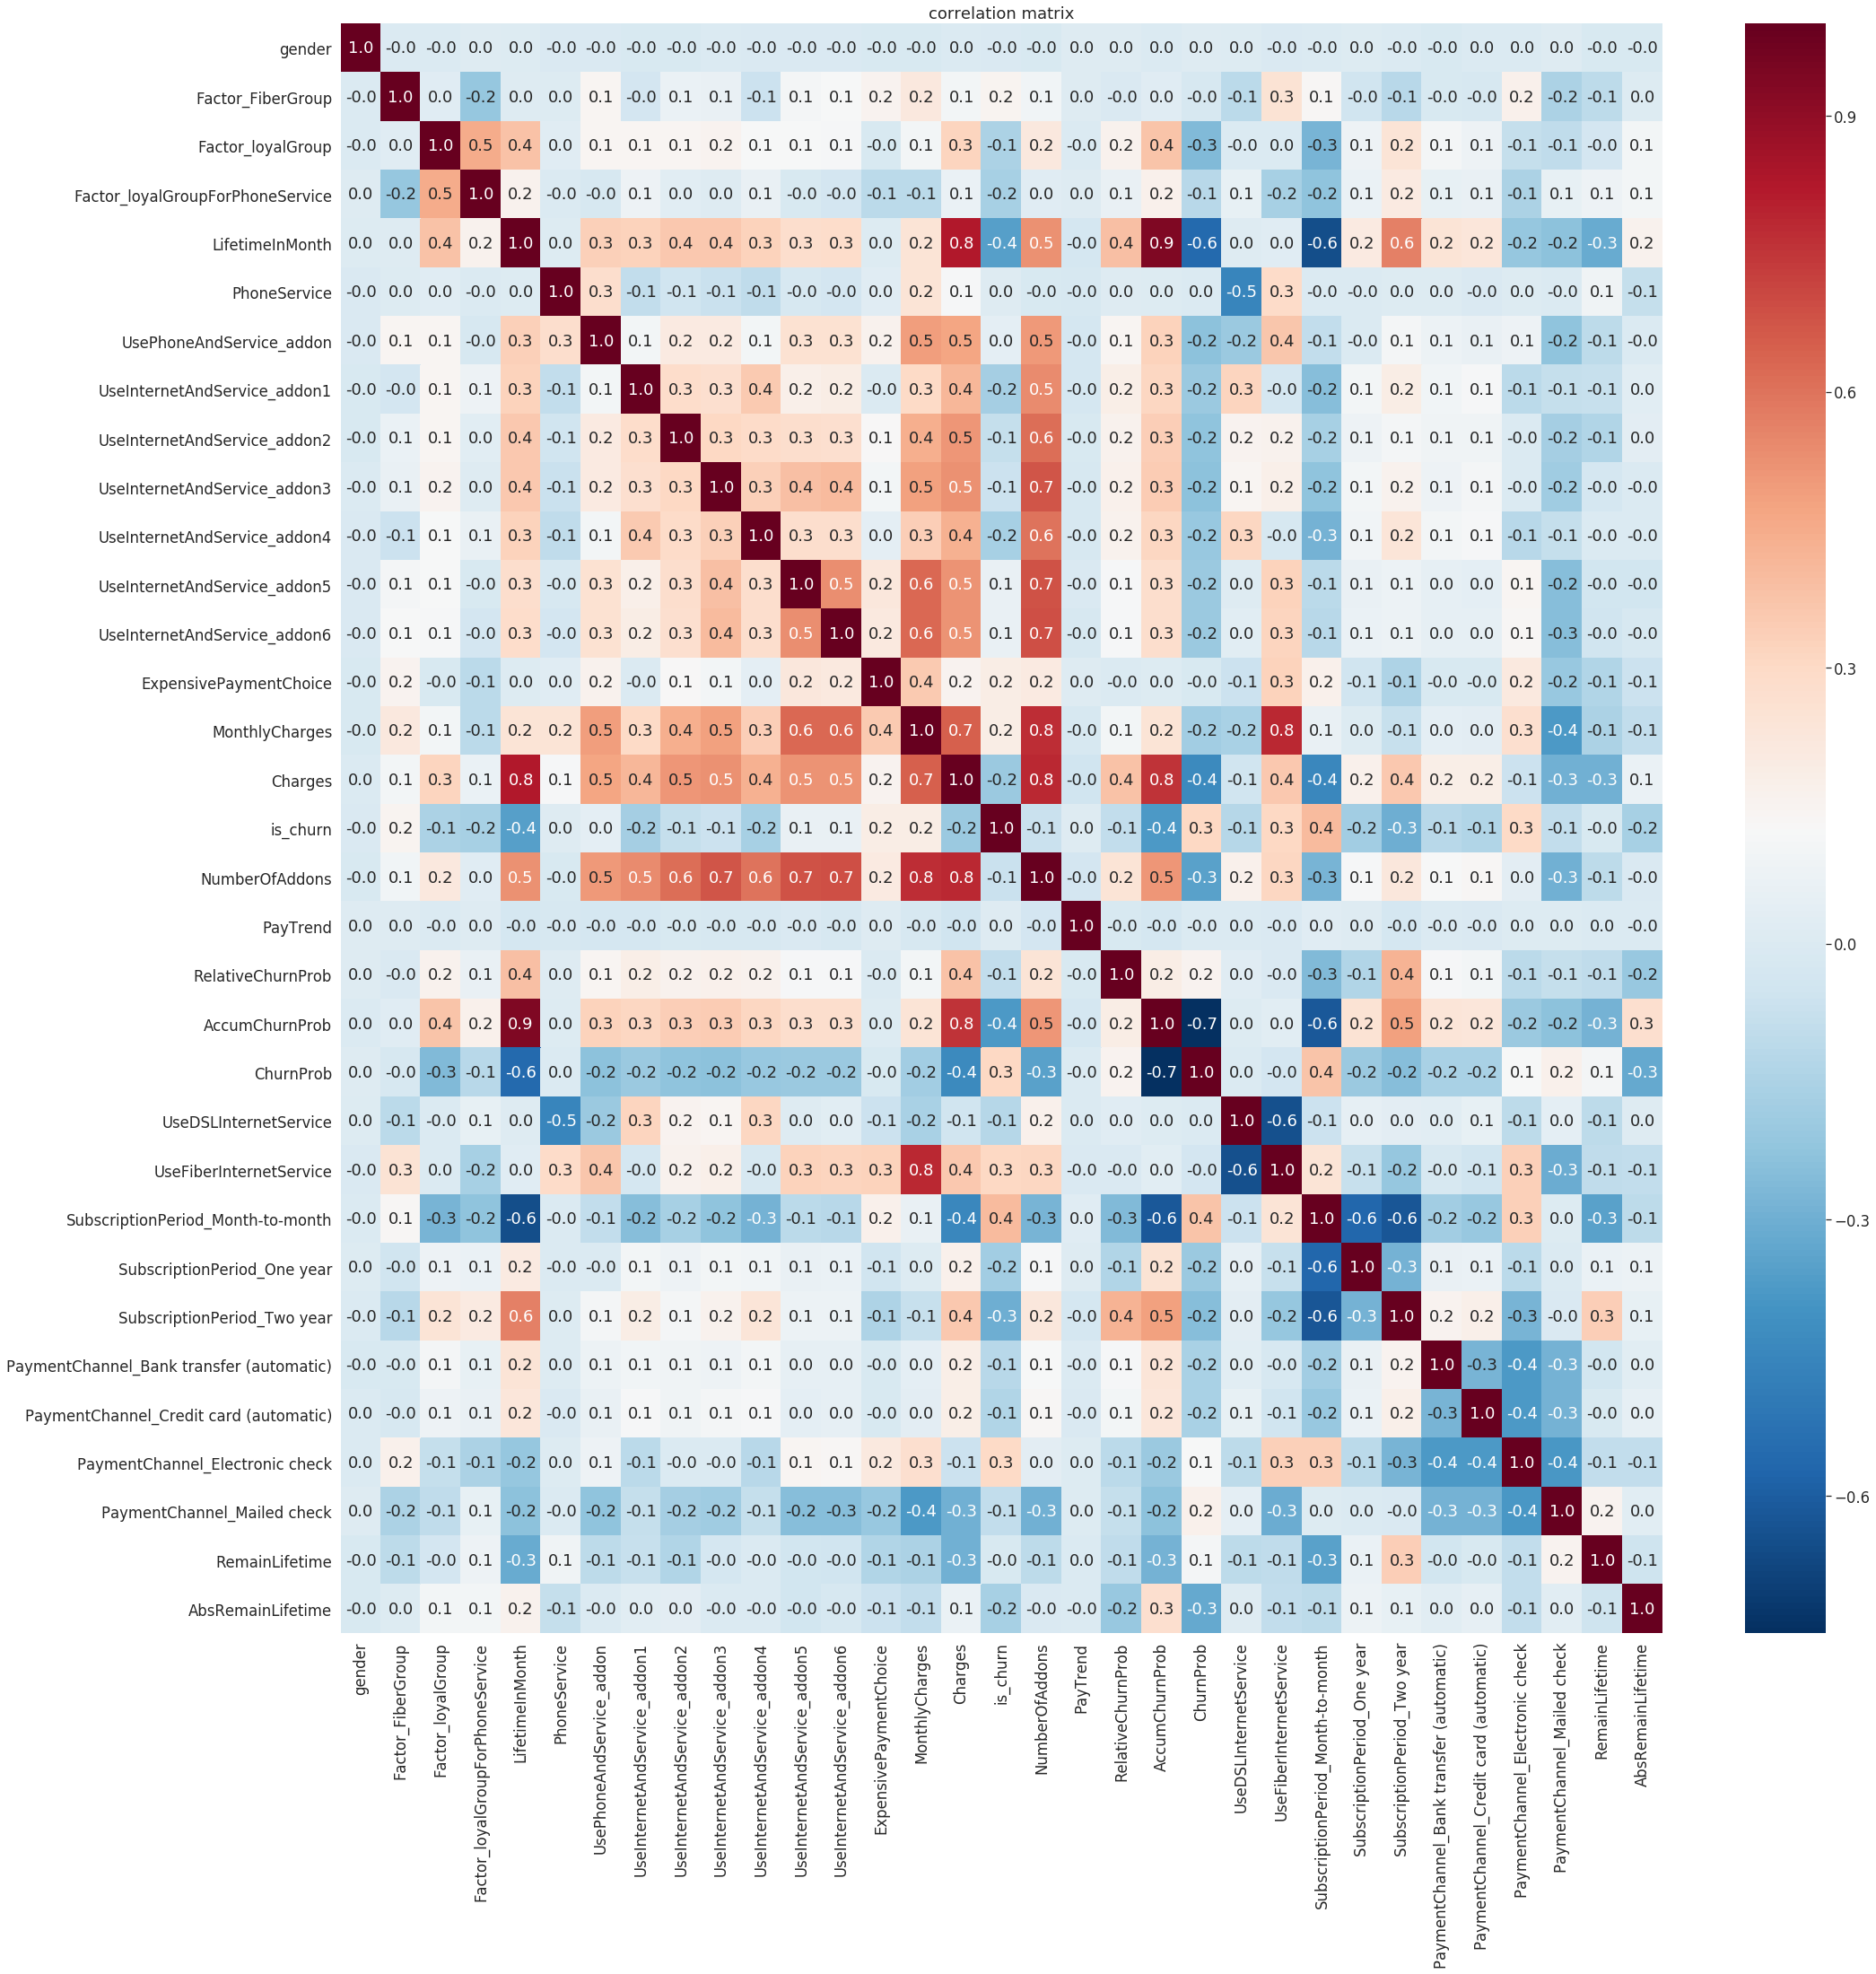

In [12]:
showSummary(dataset)
showCorr(dataset, font_scale=1.5)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


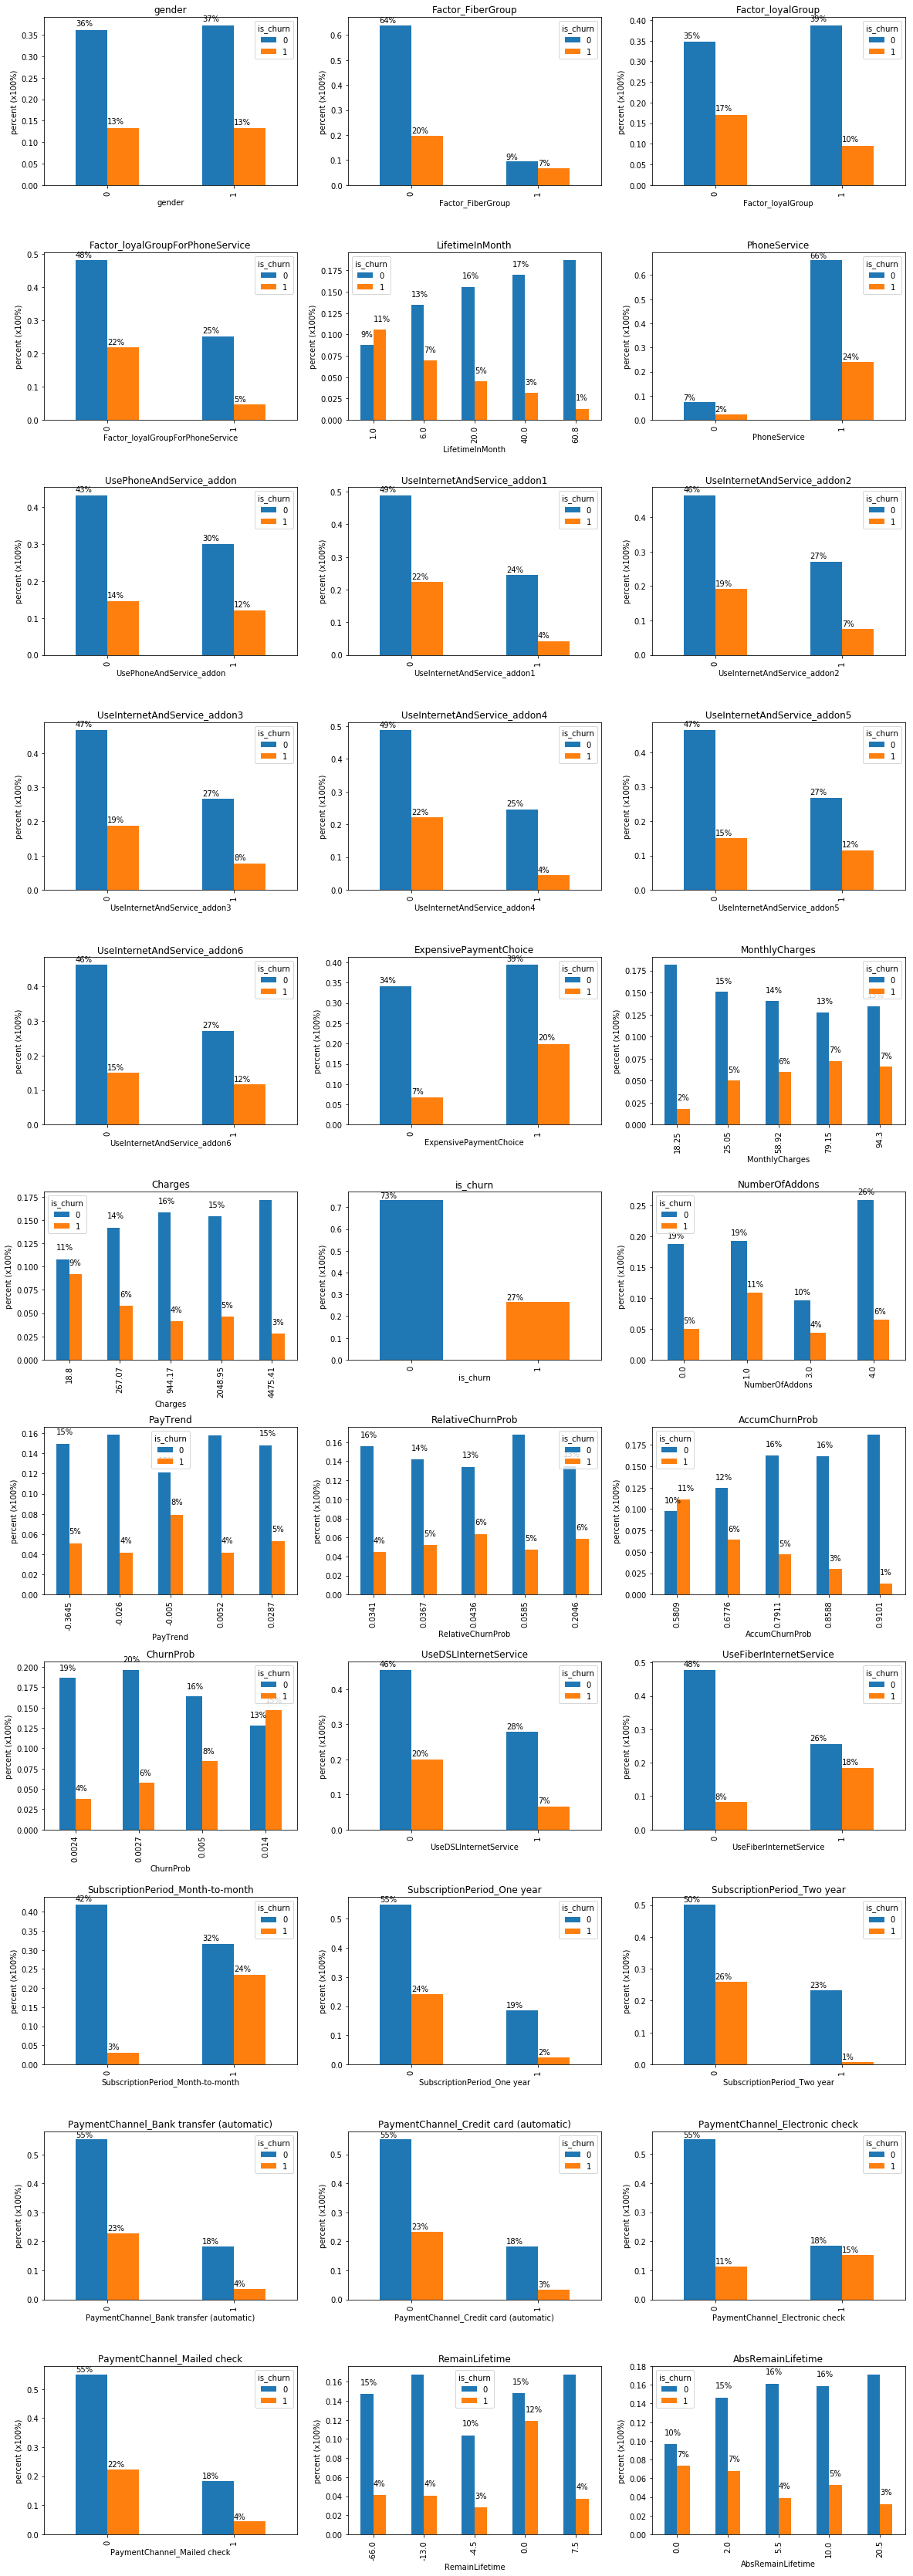

In [13]:
fig, axes = plt.subplots(11,3,figsize=(20,60))
for col, ax in zip(dataset.columns, axes.flatten()):
    
    if col == 'is_churn':
        tmp = dataset[col].value_counts()
        
    elif dataset[col].nunique() <= 2:
        # categorical feature
        tmp = dataset[[col, 'is_churn']].pivot_table(index='is_churn',columns=col, aggfunc=len)
        
    else:
        # numeric feature: bin into hitogram
        bin_edges = np.quantile( dataset[col], q=[0,0.2,0.4,0.6,0.8,1] )
        tmp1 = pd.DataFrame({'edge_lo': bin_edges[:-1].round(4),
                             'boundary': ['%.2f,\n%.2f'%(i,j) for i,j in zip(bin_edges[:-1], bin_edges[1: ])] })
        tmp2 = dataset[[col, 'is_churn']]
        tmp2[col] = tmp2[col].astype(float)
        
        tmp = pd.merge_asof( tmp2.sort_values(col), 
                             tmp1.sort_values('edge_lo'), 
                             left_on=col, right_on='edge_lo')
        tmp = tmp[['is_churn','edge_lo']].pivot_table(index='is_churn',columns='edge_lo', aggfunc=len)
        tmp = tmp.reindex(sorted(tmp.columns), axis=1)
        
    tmp.div(tmp.sum().sum()).transpose().plot(kind='bar', ax=ax)

    for p in ax.patches:
        width, height = p.get_width(), p.get_height()
        x, y = p.get_xy() 
        ax.annotate('{:.0%}'.format(height), (x, y + height + 0.01))
    
    ax.set_title(col)
    ax.set_xlabel(col)
    ax.set_ylabel('percent (x100%)')

plt.subplots_adjust(hspace=0.4)
plt.show()


In [14]:
# save dataset
dataset.to_csv('./checkpoint01_dataset.csv', index=False)

## E. Summary <a name='e' /></a>
1. Built dataset from 7043row x 21col to 7032row x 33col
2. Original dataset does not have client's history data, thus created new features that simulate a client's behavior by the whole population.